In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

fatal: destination path 'Neutron_Reflect' already exists and is not an empty directory.


In [2]:
cd Neutron_Reflect/

/pscratch/sd/q/qubri000/Ionic Time Dependent/Neutron_Reflect


In [3]:
## Import Python related required packages
import io
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
import random

## Import torch related packages
import torch
import torchvision
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [4]:
curves_nr = np.load("../NRSpecialLimited194438.npy")
params_nr = np.load("../ParametersSpecialLimited194438.npy")

In [5]:

#log curves
log_curves_nr = np.log10(curves_nr)
print(curves_nr.shape)

(3000000, 2, 308)


In [6]:
#Normalize the curves 

#First finding the min/max
x_val=log_curves_nr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=log_curves_nr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

#Normalize
log_curves_nr[:,0,:] = (log_curves_nr[:,0,:] - x_min)/(x_max - x_min)
log_curves_nr[:,1,:] = (log_curves_nr[:,1,:] - y_min)/(y_max - y_min)

x-range =  -2.09143799234063  to  -0.7042770081123632
y-range =  -6.6996239158299415  to  3.3934698599701667


In [7]:
#First finding the min/max
ranges = []
for i in range(params_nr.shape[1]):
    min_params = float('inf')
    max_params = -float('inf')
    for j in range(len(params_nr)):
        min_params = min(min_params, params_nr[j][i])
        max_params = max(max_params, params_nr[j][i])
    for j in range(len(params_nr)):
        params_nr[j][i] -= min_params
        params_nr[j][i] /= (max_params-min_params)
    ranges.append((min_params, max_params))
print(ranges)

[(0.6007614586663932, 3.6007609079649447), (10.630171816058406, 15.630168727072471), (1.144604517616246, 3.14460323867295), (8.090370160473981e-07, 5.1454407252191645), (3.3696003399086294e-05, 159.48793998135693), (0.00010336490499440742, 114.91528218240967), (0.4215746565495717, 6.421569982995973), (4.684661317355676e-05, 181.6295615059759), (4.442623554723468e-05, 146.09802256229722), (1.4658022027269624e-06, 5.68472609835089), (34.1071539206917, 234.1069815056394), (11.719267061812474, 161.71914010806256), (0.8210261738930491, 6.821024843566894), (21.32722787039954, 221.32719642366177), (1.679152828870656e-05, 118.10062374702963), (3.182917676092245e-07, 5.615290681849478), (28.227503405428493, 228.2274109870776), (14.547872015743863, 164.54780403321155), (0.8280860200645845, 0.9198158977561942), (2.365513769610239e-07, 1.9831504315643236e-06)]


In [8]:
q = log_curves_nr[:,0]
R = log_curves_nr[:,1]

q.shape, R.shape

((3000000, 308), (3000000, 308))

In [9]:
#Encoder and Decoder defined here

d = 200
dilation = 51
padding = 25

class Encoder(nn.Module):
    def __init__(self, layers, latent_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        addition = 255/layers
        curr = 1
        for hdim in range(layers-1):
            self.layers.append(nn.Conv1d(int(curr+0.5), int(curr+addition+0.5),51,padding=25))
            self.layers.append(nn.BatchNorm1d(int(curr+addition+0.5)))
            self.layers.append(nn.ReLU(True))
            curr += addition
        self.layers.append(nn.Conv1d(int(curr+0.5), 256, 51, padding=25))
        self.layers.append(nn.BatchNorm1d(256))
        self.layers.append(nn.ReLU(True))
        self.linear1 = nn.Linear(256*308,latent_dim)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        #(x, 2, 2000)
        return torch.sigmoid(x)

class Decoder(nn.Module):
    
    def __init__(self,layers, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim,256*308)
        self.relu1 = nn.ReLU(True)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256,308))
        self.layers = nn.ModuleList()
        addition = 255/layers
        curr = 256
        for hdim in range(layers-1):
            self.layers.append(nn.ConvTranspose1d(int(curr+0.5), int(curr-addition+0.5),51,padding=25))
            self.layers.append(nn.BatchNorm1d(int(curr-addition+0.5)))
            self.layers.append(nn.ReLU(True))
            curr -= addition
        self.layers.append(nn.ConvTranspose1d(int(curr+0.5), 1, 51, padding=25))
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.unflatten(x)
        for layer in self.layers:
            x = layer(x)
        #(x, 2, 2000)
        return torch.sigmoid(x)

In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 2.15481e-05

### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)

encoder = Encoder(12, d)
decoder = Decoder(12, d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=2.6324e-05)




In [11]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [12]:
# Move both the encoder and the decoder to the selected device
encoder.to(device)

Encoder(
  (layers): ModuleList(
    (0): Conv1d(1, 22, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(22, 44, kernel_size=(51,), stride=(1,), padding=(25,))
    (4): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(44, 65, kernel_size=(51,), stride=(1,), padding=(25,))
    (7): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(65, 86, kernel_size=(51,), stride=(1,), padding=(25,))
    (10): BatchNorm1d(86, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(86, 107, kernel_size=(51,), stride=(1,), padding=(25,))
    (13): BatchNorm1d(107, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Conv1d(107,

In [13]:
decoder.to(device)

Decoder(
  (linear1): Linear(in_features=200, out_features=78848, bias=True)
  (relu1): ReLU(inplace=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 308))
  (layers): ModuleList(
    (0): ConvTranspose1d(256, 235, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(235, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose1d(235, 214, kernel_size=(51,), stride=(1,), padding=(25,))
    (4): BatchNorm1d(214, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose1d(214, 192, kernel_size=(51,), stride=(1,), padding=(25,))
    (7): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose1d(192, 171, kernel_size=(51,), stride=(1,), padding=(25,))
    (10): BatchNorm1d(171, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (1

In [14]:
#splitting batch size

batch_size=256
R_m = R[:,np.newaxis,:]

xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(R_m,params_nr, size_split=0.9)
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=batch_size)
print(xtrain)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(2700000, 1, 308) (2700000, 20) (150000, 1, 308) (150000, 20) (150000, 1, 308) (150000, 20)
[[[0.65745324 0.65745324 0.65745324 ... 0.04742479 0.04712198 0.04692612]]

 [[0.65921202 0.65921202 0.65921202 ... 0.11105438 0.11065662 0.1103954 ]]

 [[0.65709932 0.65709932 0.65709932 ... 0.06936551 0.06909135 0.06891426]]

 ...

 [[0.6565185  0.6565185  0.6565185  ... 0.09280786 0.09221234 0.09181987]]

 [[0.65686922 0.65686922 0.65686922 ... 0.04843655 0.04816603 0.04799543]]

 [[0.65699558 0.65699558 0.65699558 ... 0.09431786 0.09382431 0.09349964]]]


In [15]:
## Training function
def fit(encoder, decoder, device, dataloader, loss_fn, optim):
    encoder.train().to(device)
    decoder.train().to(device)
    train_loss = []
    for data,label in dataloader:
        img = data
        img = img.to(device) 
        label = label.to(device)
        latent = encoder(img)
        decoded_img = decoder(latent)
        loss = loss_fn(decoded_img, img)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [16]:
### Valid function
def val(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval().to(device)
    decoder.eval().to(device)
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            img = img.to(device) 
            label = label.to(device)
            latent = encoder(img)
            decoded_img = decoder(latent)
            list_decoded_img.append(decoded_img.cpu())
            list_img.append(img.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img) 
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [17]:
#plotting outputs for training

dataset = train_dataset
def plot_outputs(encoder,decoder,dataset,device,n=10):
  plt.figure(figsize=(26,5.5))
  for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img,_ = dataset[i]
        img = img[:,np.newaxis,:].to(device)
        # print(img.shape)
        encoder.eval().to(device)
        decoder.eval().to(device)
        with torch.no_grad():
          decoded_img  = decoder(encoder(img))
          loss = loss_fn(decoded_img,img)
        plt.plot(img.cpu().numpy()[0][0]) 
        if i == n//2:
          ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n) 
        plt.plot(decoded_img.cpu()[0][0]) 
        if i == n//2:
          ax.set_title('Reconstructed images')
  plt.show()  

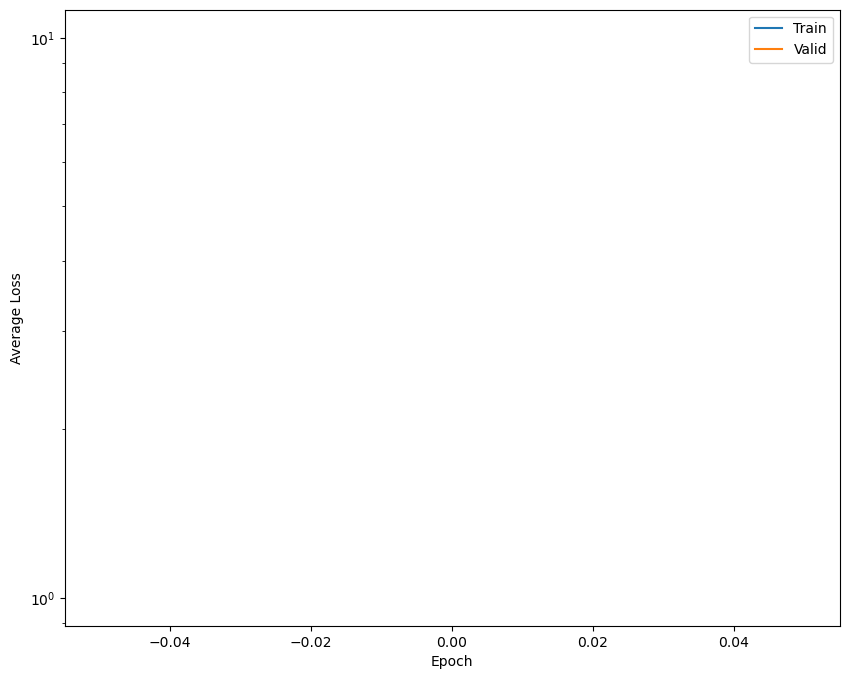

0


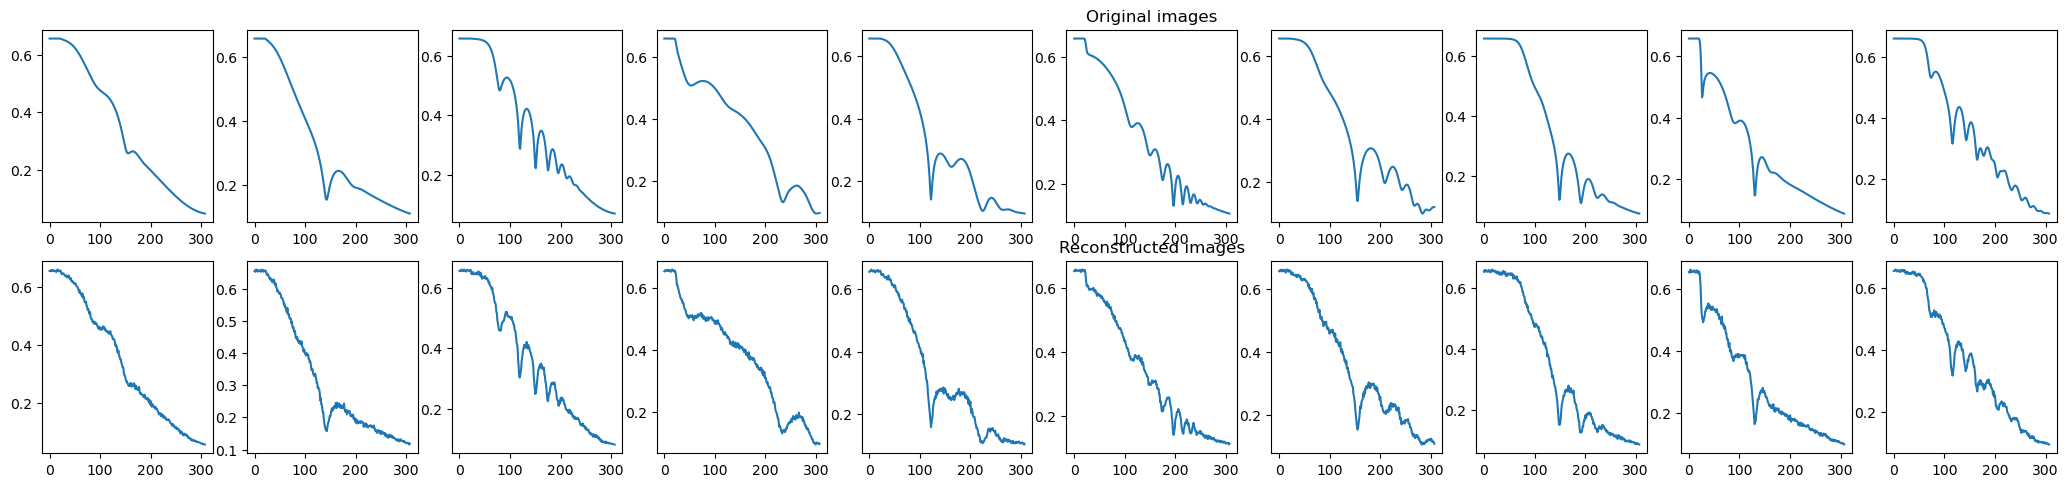

1


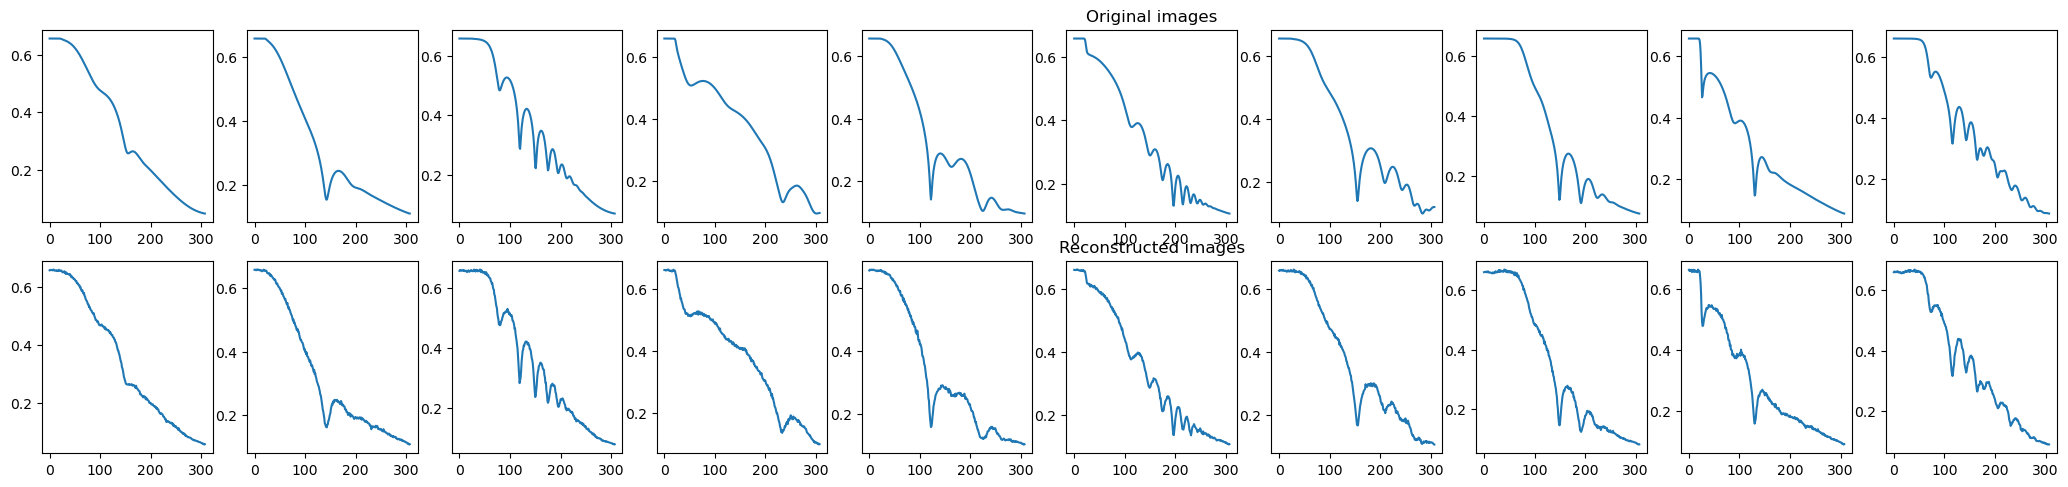

In [18]:
num_epochs=2

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  if epoch % 10 ==0:
    # Plot losses
        plt.figure(figsize=(10,8))
        plt.semilogy(diz_loss['train_loss'], label='Train')
        plt.semilogy(diz_loss['val_loss'], label='Valid')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()
        plt.show()
  print (epoch)
  train_loss = fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = val(encoder,decoder,device,valid_loader,loss_fn)
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  plot_outputs(encoder,decoder,dataset,device,n=10)

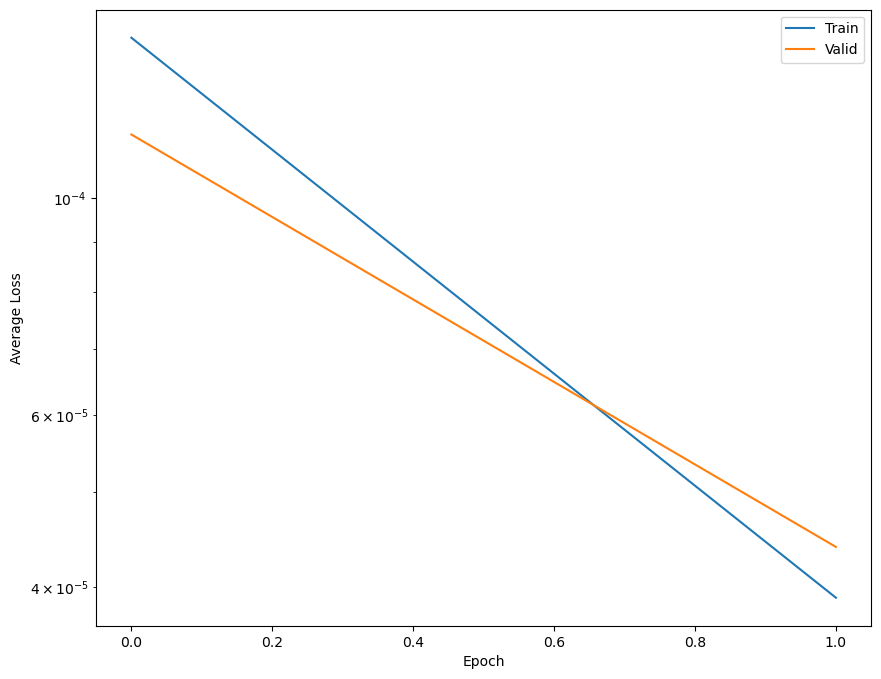

In [19]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()


In [20]:
#plotting results after training

def test10(encoder,decoder,dataset,device,loss_fn,n=10):
    plt.figure(figsize=(26,5.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img,_ = dataset[i]
      img = img[:,np.newaxis,:].to(device)
      encoder.eval().to(device)
      decoder.eval().to(device)
      with torch.no_grad():
         decoded_img  = decoder(encoder(img))
         loss = loss_fn(decoded_img,img)
         print('For image {}, the loss = {}'.format(i,loss.data))
      print(img.shape)
      plt.plot(img.cpu()[0][0]) 
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.plot(decoded_img.cpu()[0][0]) 
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 

For image 0, the loss = 3.719341475516558e-05
torch.Size([1, 1, 308])
For image 1, the loss = 9.576463526173029e-06
torch.Size([1, 1, 308])
For image 2, the loss = 2.535554813221097e-05
torch.Size([1, 1, 308])
For image 3, the loss = 1.2723699001071509e-05
torch.Size([1, 1, 308])
For image 4, the loss = 4.712432200904004e-05
torch.Size([1, 1, 308])
For image 5, the loss = 3.380690759513527e-05
torch.Size([1, 1, 308])
For image 6, the loss = 2.8234398996573873e-05
torch.Size([1, 1, 308])
For image 7, the loss = 2.1323139662854373e-05
torch.Size([1, 1, 308])
For image 8, the loss = 7.186117727542296e-05
torch.Size([1, 1, 308])
For image 9, the loss = 4.757874194183387e-05
torch.Size([1, 1, 308])


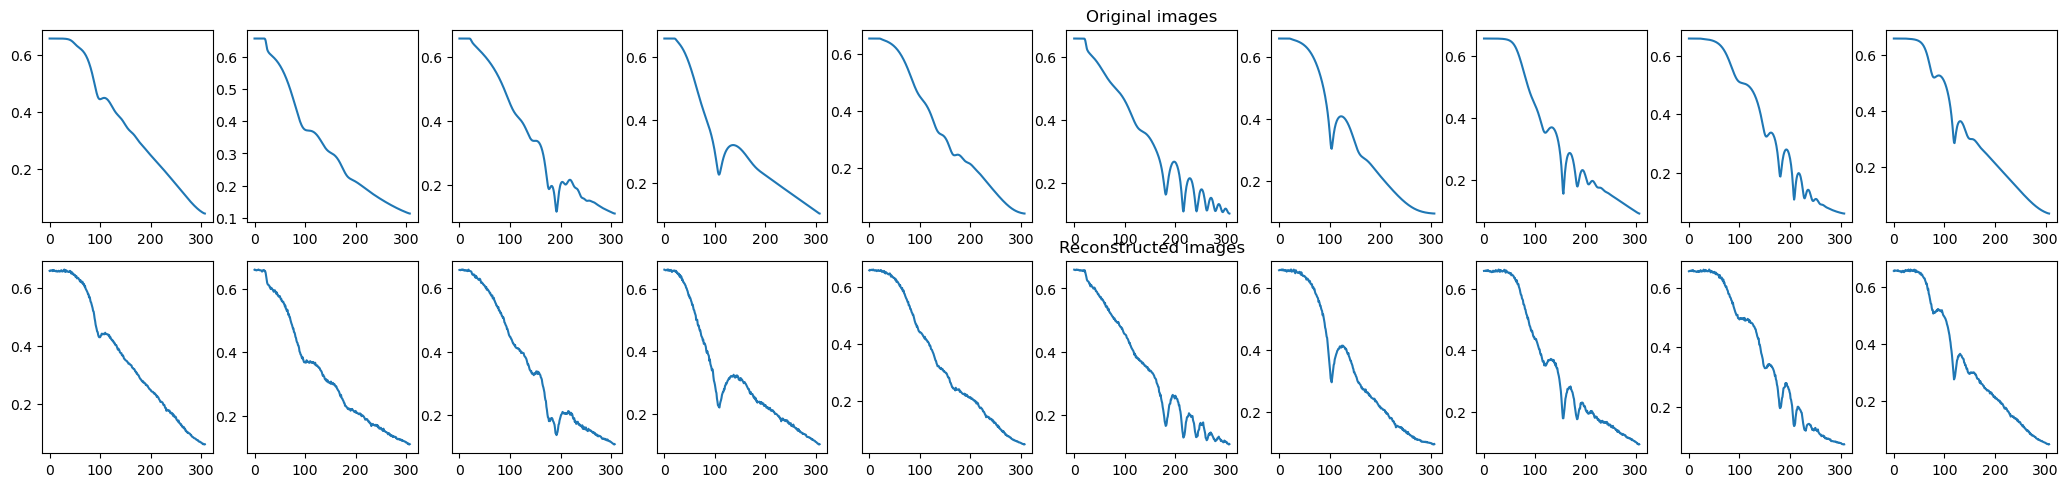

In [21]:
test10(encoder,decoder,test_dataset,device,loss_fn,n=10)


In [27]:
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/1lBIo_aC1yRNW2SYuyzCq7vQOFO0M3DYo")

Retrieving folder list


Processing file 10cLY_gZBBLyspUykzuwyYJRZ_xHlSQcr np_out_REFL_194385_combined_data_auto.npy
Processing file 1-Bg_dDjlyFfjFZVJlk_-e7ijvkDEwrVW np_out_REFL_194395_combined_data_auto.npy
Processing file 106y5IQmOlq4mzsJnTeKuVZY7P_YMBpPU np_out_REFL_194403_combined_data_auto.npy
Processing file 1-5BCbBd-500_61ZLYPkJ39dnkJq0T6TR np_out_REFL_194411_combined_data_auto.npy
Processing file 1-sVMDi3Oiz5YCl9-bVq7D0-mC9UFragB np_out_REFL_194419_combined_data_auto.npy
Processing file 15yvIOnNSoKjuZKuxXp6cLSpiyRgqtS2K np_out_REFL_194426_combined_data_auto.npy
Processing file 1-0n3qmiKTt-GrjRlPifnARqDQ_3ZTxSS np_out_REFL_194438_combined_data_auto.npy
Processing file 1035D9KjhbfLpU8hnwQUI-LqHKeTEuEpK np_out_REFL_194446_combined_data_auto.npy
Processing file 1-Z5SMdG340dBn_Y9xxykuT7xxgGoZ0x7 np_out_REFL_194455_combined_data_auto.npy
Processing file 1-INLTmMBVeENaVhvOG4yI3SCztO4fklM np_out_REFL_194463_combined_data_auto.npy
Processing file 102we8PtrDZz7MGXGD18CdkHIzOPoCALQ np_out_REFL_194471_combined_da

Retrieving folder list completed
Building directory structure


AttributeError: 'NoneType' object has no attribute 'groups'

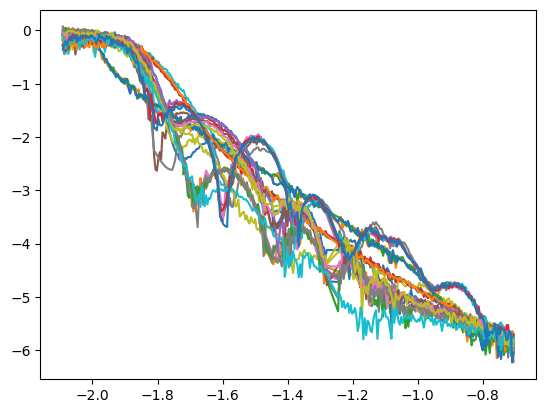

In [38]:
#Load in Polyzwitterion Experimental Data
import os
directory = "npoutputs2/"

totalDataIonic = []
parametersIonic = []
count = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # if os.path.isfile(f):
    #     print(f[10:])
    parametersIonic.append([])
    # print(f[23:29])
    for j in range(10):
        parametersIonic[count].append(int(f[23:29]))
    count += 1

    currData = np.load(directory +f[10:])
    xptIonic = []
    yptIonic = []
    for j in range(len(currData)):
      xptIonic.append(currData[j][0])
      yptIonic.append(currData[j][1])
    np.array(xptIonic)
    np.array(yptIonic)
    # xpt2 = np.log10(xpt2)
    # ypt2 = np.log10(ypt2)
    totalDataIonic.append([xptIonic,yptIonic])
totalDataIonic = np.stack(totalDataIonic)
totalDataIonic = np.log10(totalDataIonic)
for x in range(len(totalDataIonic)):
  plt.plot(totalDataIonic[x][0],totalDataIonic[x][1])

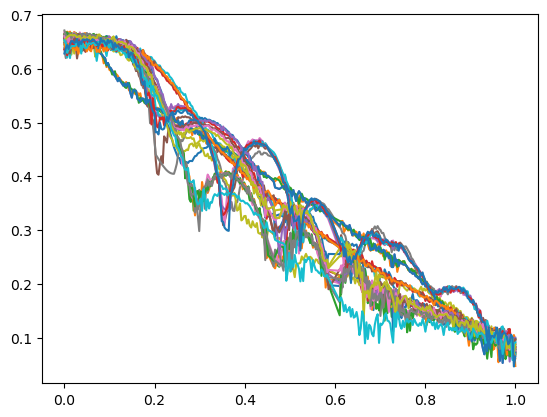

In [39]:
#normalizing experimental data and plotting it again
x_pointsIonic = []
y_pointsIonic = []
for curve in totalDataIonic:
    x_pointsIonic.append(curve[0])
    y_pointsIonic.append(curve[1])
for i in range(len(y_pointsIonic)):
    for j in range(len(y_pointsIonic[0])):
        x_pointsIonic[i][j] -= x_min
        y_pointsIonic[i][j] -= y_min
        x_pointsIonic[i][j] /= (x_max - x_min)
        y_pointsIonic[i][j] /= (y_max - y_min)
totalDataIonic2 = []
for i in range(len(y_pointsIonic)):
    totalDataIonic2.append([x_pointsIonic[i],y_pointsIonic[i]])
totalDataIonic2 = np.stack(totalDataIonic2)
totalDataIonic2.shape
for x in range(totalDataIonic.shape[0]):
  plt.plot(totalDataIonic[x][0],totalDataIonic[x][1])

In [40]:
#splitting experimental data
totalDataIonic.shape
RIonic = totalDataIonic[:,1]
parametersIonic = np.stack(parametersIonic)
batch_size=64
RIonic_m = RIonic[:,np.newaxis,:]
xtrainIonic, ytrainIonic, xvalIonic, yvalIonic, xtestIonic, ytestIonic = \
dpre.split_input_arrays(RIonic_m,parametersIonic, size_split=0.95)
#Prepare data files, continuation
train_datasetIonic, valid_datasetIonic, test_datasetIonic, train_loaderIonic, valid_loaderIonic, test_loaderIonic = \
dpre.get_dataloaders_fromsplitarrays(xtrainIonic,ytrainIonic,xvalIonic,yvalIonic,xtestIonic,ytestIonic,batch_size=batch_size)
print(train_datasetIonic)
for data, label in train_datasetIonic:
    print(label)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(29, 1, 308) (29, 10) (1, 1, 308) (1, 10) (1, 1, 308) (1, 10)
tensor([194622., 194622., 194622., 194622., 194622., 194622., 194622., 194622.,
        194622., 194622.])
tensor([194455., 194455., 194455., 194455., 194455., 194455., 194455., 194455.,
        194455., 194455.])
tensor([194630., 194630., 194630., 194630., 194630., 194630., 194630., 194630.,
        194630., 194630.])
tensor([194446., 194446., 194446., 194446., 194446., 194446., 194446., 194446.,
        194446., 194446.])
tensor([194590., 194590., 194590., 194590., 194590., 194590., 194590., 194590.,
        194590., 194590.])
tensor([194403., 194403., 194403., 194403., 194403., 194403., 194403., 194403.,
        194403., 194403.])
tensor([194582., 194582., 194582., 194582., 194582., 194582., 194582., 194582.,
        194582., 194582.])
tensor([194508., 194508., 194508., 194508., 194508., 194508., 194508., 194508.,
        194508., 194508.])
tenso

In [41]:
#plots experimental NR curves on top and respective SLD prediction below

def plot_outputs3(Encoder, Decoder,dataset,device,loss_fn, n=10, ):
  plt.figure(figsize=(26,5.5))
  train_loss= []
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    img, label =dataset[i]
    img = img[:,np.newaxis,:].to(device) 
    Encoder.eval().to(device)
    Decoder.eval().to(device)
    with torch.no_grad():
      decoded_img  = Decoder(Encoder(img))
    print(int(label[0].item()))
    plt.plot(img.cpu().numpy()[0][0])
    if i == n//2:
      ax.set_title('Neutron Reflectivity images')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_img.cpu()[0][0]) 
    if i == n//2:
      ax.set_title('SLD images')
  plt.show()

194622
194455
194630
194446
194590
194403
194582
194508
194574
194438


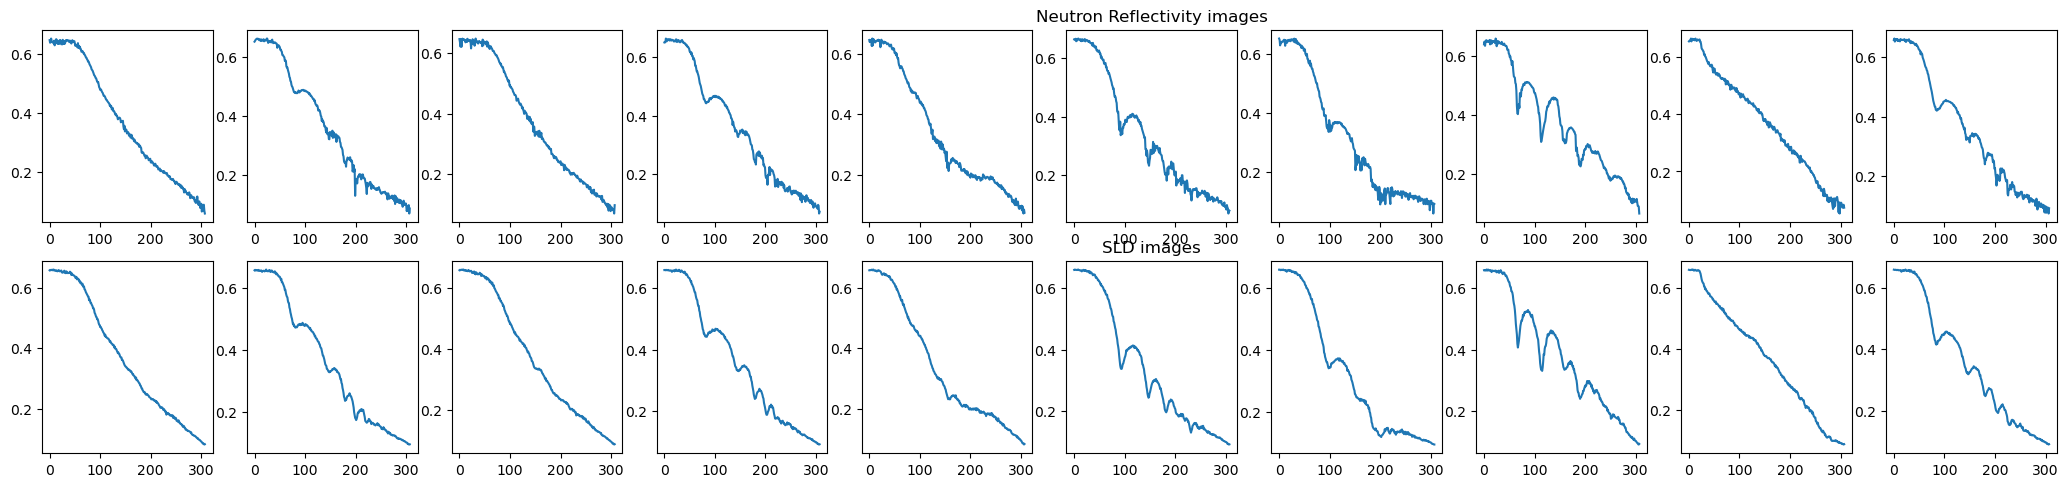

In [42]:
plot_outputs3(encoder, decoder, train_datasetIonic, device, loss_fn)

In [43]:
#plots experimental NR curves on top and respective SLD prediction below

def plot_outputs3(Encoder, Decoder,dataset,device,loss_fn, n=10, ):
  # plt.figure(figsize=(26,5.5))
  train_loss= []
  for i in range(len(dataset)):
    # ax = plt.subplot(2,n,i+1)
    img, label =dataset[i]
    if int(label[0].item()) != 194438:
        continue
    img = img[:,np.newaxis,:].to(device) 
    Encoder.eval().to(device)
    Decoder.eval().to(device)
    with torch.no_grad():
      decoded_img  = Decoder(Encoder(img))
    print(int(label[0].item()))
    plt.plot(img.cpu().numpy()[0][0])
    # if i == n//2:
    #   ax.set_title('Neutron Reflectivity images')
    # ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_img.cpu()[0][0]) 
    # if i == n//2:
    #   ax.set_title('SLD images')
  plt.show()

194438


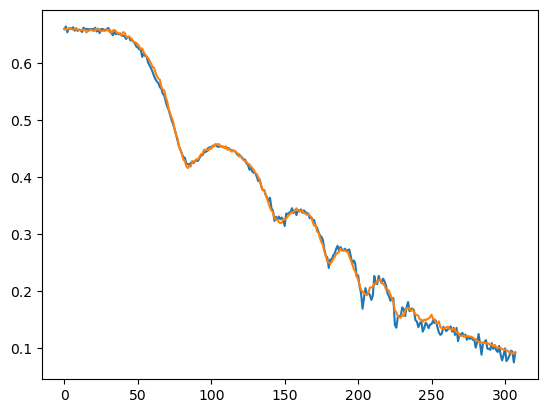

In [44]:
plot_outputs3(encoder, decoder, train_datasetIonic, device, loss_fn)

In [45]:
## Method to take a model and dataloader, and output 4 arrays as pytorch tensors:
## Input curves, output curves, latent space vectors, and chi parameters
def get_latent_variables2(encoder, decoder, device, dataloader):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        # Define the lists to store the original images, the recreated ones,
        # the latent variables and the corresponding labels
        list_img = []
        list_decoded_img = []
        list_latent = []
        list_labels = []

        for  data, label in dataloader:
            img = data
            # print(img.shape)
            img = img.to(device)
            # Encode and Decode data
            latent = encoder(img)
            decoded_img = decoder(latent)
            # Append the network output and the original image to the lists
            list_img.append(img.cpu())
            list_decoded_img.append(decoded_img.cpu())
            list_latent.append(latent.cpu())
            list_labels.append(label.cpu())
# Convert list into a torch.tensor
        t_img = torch.cat(list_img)
        t_decoded_img = torch.cat(list_decoded_img)
        t_latent = torch.cat(list_latent) 
        t_labels = torch.cat(list_labels)
    return t_img, t_decoded_img, t_latent, t_labels

In [46]:
def get_dataloaders2(crv_tr, chi_tr, crv_val, chi_val, crv_tst, chi_tst, batch_size):

    tr_set = torch.utils.data.TensorDataset(crv_tr, chi_tr)
    tr_load = torch.utils.data.DataLoader(tr_set, batch_size = batch_size, shuffle = True)

    val_set = torch.utils.data.TensorDataset(crv_val, chi_val)
    val_load = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

    tst_set = torch.utils.data.TensorDataset(crv_tst, chi_tst)
    tst_load = torch.utils.data.DataLoader(tst_set, batch_size = batch_size, shuffle = True)

    return [tr_set, val_set, tst_set, tr_load, val_load, tst_load]

In [47]:
#data splitting
print(R_m.shape)
print(params_nr.shape)
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(R_m,params_nr, size_split=0.9)
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=batch_size)


(3000000, 1, 308)
(3000000, 20)
xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(2700000, 1, 308) (2700000, 20) (150000, 1, 308) (150000, 20) (150000, 1, 308) (150000, 20)


In [48]:
#obtaining latency space of each NR curve to be compared with the parameters for MLP

full_data_train = get_latent_variables2(encoder,decoder,device,train_loader)
full_data_valid = get_latent_variables2(encoder,decoder,device,valid_loader)
full_data_test = get_latent_variables2(encoder,decoder,device,test_loader)
mlp_input_data = [full_data_train[2], full_data_train[3], full_data_valid[2], full_data_valid[3], full_data_test[2], full_data_test[3]]
device
# print(full_data_train[2])

device(type='cuda')

In [49]:
#more data splitting
mlp_tr_data, mlp_val_data, mlp_tst_data, mlp_tr_load, mlp_val_load, mlp_tst_load = get_dataloaders2(*mlp_input_data, batch_size)

In [50]:
import refl1d
from refl1d.names import *

In [51]:
#MLP Structure

class deep_MLP2(nn.Module):
    def __init__(self, input_size, n_label):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, 300))
        self.layers.append(nn.BatchNorm1d(300))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(300, 500))
        self.layers.append(nn.BatchNorm1d(500))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(500, 700))
        self.layers.append(nn.BatchNorm1d(700))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(700, 900))
        self.layers.append(nn.BatchNorm1d(900))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(900, 1500))
        self.layers.append(nn.BatchNorm1d(1500))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(1500, 900))
        self.layers.append(nn.BatchNorm1d(900))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(900, 500))
        self.layers.append(nn.BatchNorm1d(500))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(500, 300))
        self.layers.append(nn.BatchNorm1d(300))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(300, 120))
        self.layers.append(nn.BatchNorm1d(120))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(120,60))
        self.layers.append(nn.BatchNorm1d(60))
        self.layers.append(nn.ReLU(True))
        self.layers.append(nn.Linear(60, n_label))
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x= torch.sigmoid(x)
        return x

In [52]:
#Training function for MLP

def trainMLP(model, train_loader, val_loader, epochs, loss_fn, ranger):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr = 0.0001)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        shot_loss = []
        count = 0
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            opt.zero_grad()
            output = model(data)
            loss = loss_fn(output, label)
            loss.backward()
            opt.step()
            shot_loss.append(loss.item())
            count += 1
        epoch_loss = np.mean(shot_loss)
        train_loss.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            val_shot_loss = []
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = loss_fn(output, label)
                val_shot_loss.append(loss.item())
            val_epoch_loss = np.mean(val_shot_loss)
            val_loss.append(val_epoch_loss)

        print('Epoch: ' + str(epoch + 1) + ', train loss: ' + str(epoch_loss) + ', valid loss: ' + str(val_epoch_loss))
    
    return train_loss, val_loss

In [53]:
#training

percep = deep_MLP2(d, params_nr.shape[1]).cuda()
print(d)
train_loss, val_loss = trainMLP(percep, mlp_tr_load, mlp_val_load, 10, torch.nn.MSELoss(), ranges)

200
Epoch: 1, train loss: 0.05823308787092028, valid loss: 0.052784447202223764
Epoch: 2, train loss: 0.05109635721259875, valid loss: 0.05004324384173537
Epoch: 3, train loss: 0.04876039469009049, valid loss: 0.04826270372673564
Epoch: 4, train loss: 0.047278368643458434, valid loss: 0.047194594083474664
Epoch: 5, train loss: 0.04618230111276404, valid loss: 0.04632334095193868
Epoch: 6, train loss: 0.04529125084163646, valid loss: 0.04641725715097205
Epoch: 7, train loss: 0.04453725571824234, valid loss: 0.04565521588059517


KeyboardInterrupt: 

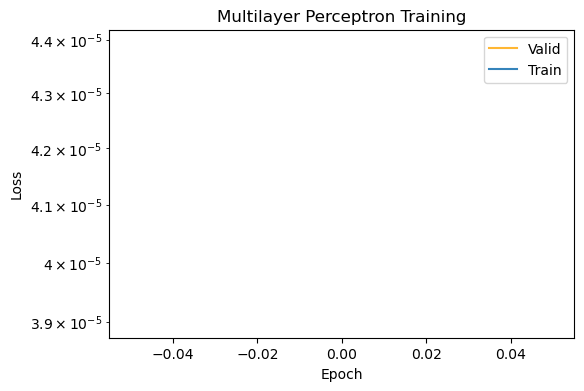

In [54]:
#plotting loss

plt.figure(figsize=(6,4))
plt.semilogy(val_loss, label='Valid', color = 'orange', alpha=0.8)
plt.semilogy(train_loss, label='Train', alpha=.9)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multilayer Perceptron Training')
plt.legend()

In [55]:
#unnormalizing output parameters

def unnormalizeParams(params, ranger):
    for i in range(len(ranger)):
        for j in range(len(params)):
            params[j][i] *= (ranger[i][1]-ranger[i][0])
            params[j][i] += ranger[i][0]
    return params

In [56]:
#testing accuracy on training data

train_samples = []

for i, sample in enumerate(mlp_tr_data):
    if i > 0:
        break
    latent = sample[0].to(device)
    latent = latent[np.newaxis,:]
    label_val = sample[1].to(device)
    percep.eval()
    with torch.no_grad():
        output  = percep(latent)
    out_sample = {"parameter"+str(i+1): enc for i, enc in enumerate(output)}
    for i in range(params_nr.shape[1]):
      label_index = 'parameter'+str(i+1)
      out_sample[label_index] = [output[0][i],label_val[i]]
    train_samples.append(out_sample)
print(train_samples[0])

{'parameter1': [tensor(0.4873, device='cuda:0'), tensor(0.6071, device='cuda:0')], 'parameter2': [tensor(0.3650, device='cuda:0'), tensor(0.4321, device='cuda:0')], 'parameter3': [tensor(0.5031, device='cuda:0'), tensor(0.8046, device='cuda:0')], 'parameter4': [tensor(0.5485, device='cuda:0'), tensor(0.4776, device='cuda:0')], 'parameter5': [tensor(0.3114, device='cuda:0'), tensor(0.1861, device='cuda:0')], 'parameter6': [tensor(0.5033, device='cuda:0'), tensor(0.3859, device='cuda:0')], 'parameter7': [tensor(0.8467, device='cuda:0'), tensor(0.7461, device='cuda:0')], 'parameter8': [tensor(0.7746, device='cuda:0'), tensor(0.9714, device='cuda:0')], 'parameter9': [tensor(0.2938, device='cuda:0'), tensor(0.1157, device='cuda:0')], 'parameter10': [tensor(0.7666, device='cuda:0'), tensor(0.9881, device='cuda:0')], 'parameter11': [tensor(0.5973, device='cuda:0'), tensor(0.1748, device='cuda:0')], 'parameter12': [tensor(0.4401, device='cuda:0'), tensor(0.6490, device='cuda:0')], 'parameter13

In [57]:
#testing accuracy on experimental data

train_samplesExperimental = []
for data, label in train_datasetIonic:
    img = data.to(device)
    label_val = label
    encoder.eval()
    img = img[:,np.newaxis,:].to(device)
    latent = encoder(img)
    percep.eval()
    with torch.no_grad():
        out_label  = percep(latent)
    out_label = out_label.cpu().numpy()
    out_sample = {"parameter"+str(i+1): enc for i, enc in enumerate(out_label)}
    out_label = unnormalizeParams(out_label, ranges)
    for i in range(params_nr.shape[1]):
      label_index = 'parameter'+str(i+1)
      out_sample[label_index] = out_label[0][i]
    train_samplesExperimental.append([out_sample, label_val[0]])
    if int(label_val[0].item()) == 194438:
        print(repr(out_label))
        print(eval(repr(out_label)[7:-23]))
        x = eval(repr(out_label)[7:-23])
        print(x)
print(train_samplesExperimental[0])

array([[2.13612604e+00, 1.27673283e+01, 2.19266582e+00, 1.49797010e+00,
        7.33593674e+01, 2.67607899e+01, 2.89504600e+00, 8.03214340e+01,
        4.55831108e+01, 3.36598158e+00, 1.42659637e+02, 8.01085663e+01,
        3.23335528e+00, 1.21073364e+02, 1.81380577e+01, 3.55270934e+00,
        1.05193756e+02, 1.32774200e+02, 8.84982109e-01, 5.99226325e-07]],
      dtype=float32)
[2.13612604, 12.7673283, 2.19266582, 1.4979701, 73.3593674, 26.7607899, 2.895046, 80.321434, 45.5831108, 3.36598158, 142.659637, 80.1085663, 3.23335528, 121.073364, 18.1380577, 3.55270934, 105.193756, 132.7742, 0.884982109, 5.99226325e-07]
[2.13612604, 12.7673283, 2.19266582, 1.4979701, 73.3593674, 26.7607899, 2.895046, 80.321434, 45.5831108, 3.36598158, 142.659637, 80.1085663, 3.23335528, 121.073364, 18.1380577, 3.55270934, 105.193756, 132.7742, 0.884982109, 5.99226325e-07]
[{'parameter1': 2.9382493, 'parameter2': 14.250237, 'parameter3': 2.68603, 'parameter4': 0.74176246, 'parameter5': 68.43106, 'parameter6'

In [58]:
#This block is the class that is used to generate the SLD and NR curves

from scipy.interpolate import CubicSpline
import random
def calculate_reflectivity(q, model_description, q_resolution=0.0294855):
    """
        Reflectivity calculation using refl1d
    """
    # print(model_description['scale'], model_description['background'])
    zeros = np.zeros(len(q))
    dq = q_resolution * q / 2.355

    # The QProbe object represents the beam
    probe = QProbe(q, dq, data=(zeros, zeros))

    layers = model_description['layers']
    sample = Slab(material=SLD(name=layers[0]['name'],
                               rho=layers[0]['sld']), interface=layers[0]['roughness'])
    # Add each layer
    for l in layers[1:]:
        sample = sample | Slab(material=SLD(name=l['name'],
                               rho=l['sld'], irho=l['isld']),
                               thickness=l['thickness'], interface=l['roughness'])

    probe.background = Parameter(value=model_description['background'], name='background')
    expt = Experiment(probe=probe, sample=sample)
    print(model_description)
    q, r = expt.reflectivity()
    return model_description['scale'] * r
class ReflectivityModels(object):
        # Neutrons come in from the last item in the list

    def __init__(self,parameters, ratio, q=None, name='polymer'):
        
        self.parameters = [
                    dict(i=0, par='roughness', bounds=[parameters[0]-3*ratio if parameters[0]-3*ratio > 0 else 0, 3*ratio+parameters[0]]),

          dict(i=1, par='thickness', bounds=[parameters[1]-5*ratio if parameters[1]-5*ratio > 0 else 0, 5*ratio+parameters[1]]),
          dict(i=1, par='roughness', bounds=[parameters[2] -2*ratio if parameters[2]-2*ratio > 0 else 0, 2*ratio+parameters[2]]),

          # The next three layers are the polymer
          dict(i=2, par='sld', bounds=[parameters[3]-6*ratio if parameters[3]-6*ratio > 0 else 0, 6*ratio+parameters[3]]),
          dict(i=2, par='thickness', bounds=[parameters[4]-200*ratio if parameters[4]-200*ratio > 0 else 0, 200*ratio+parameters[4]]),
          dict(i=2, par='roughness', bounds=[parameters[5]-150*ratio if parameters[5]-150*ratio > 0 else 0, 150*ratio+parameters[5]]),
          dict(i=3, par='sld', bounds=[parameters[6]-6*ratio if parameters[6]-6*ratio > 0 else 0,6*ratio+parameters[6]]),
          dict(i=3, par='thickness', bounds=[parameters[7]-200*ratio if parameters[7]-200*ratio > 0 else 0, 200*ratio+parameters[7]]),
          dict(i=3, par='roughness', bounds=[parameters[8]-150*ratio if parameters[8]-150*ratio > 0 else 0, 150*ratio+parameters[8]]),
            dict(i=4, par='sld', bounds=[parameters[9]-6*ratio if parameters[9]-6*ratio>0 else 0,6*ratio+parameters[9]]),
          dict(i=4, par='thickness', bounds=[parameters[10]-200*ratio if parameters[10]-200*ratio>0 else 0, 200*ratio+parameters[10]]),
          dict(i=4, par='roughness', bounds=[parameters[11]-150*ratio if parameters[11]-150*ratio>0 else 0, 150*ratio+parameters[11]]),
                                dict(i=5, par='sld', bounds=[parameters[12]-6*ratio if parameters[12]-6*ratio>0 else 0,6*ratio+parameters[12]]),
          dict(i=5, par='thickness', bounds=[parameters[13]-200*ratio if parameters[13]-200*ratio>0 else 0, 200*ratio+parameters[13]]),
          dict(i=5, par='roughness', bounds=[parameters[14]-150*ratio if parameters[14]-150*ratio>0 else 0, 150*ratio+parameters[14]]),
                                dict(i=6, par='sld', bounds=[parameters[15]-6*ratio if parameters[15]-6*ratio>0 else 0,6*ratio+parameters[15]]),
          dict(i=6, par='thickness', bounds=[parameters[16]-200*ratio if parameters[16]-200*ratio>0 else 0, 200*ratio+parameters[16]]),
          dict(i=6, par='roughness', bounds=[parameters[17]-150*ratio if parameters[17]-150*ratio>0 else 0, 150*ratio+parameters[17]]),
          #   dict(i=7, par='sld', bounds=[parameters[18]-6*ratio if parameters[18]-6*ratio>0 else 0,6*ratio+parameters[18]]),
          # dict(i=7, par='thickness', bounds=[parameters[19]-200*ratio if parameters[19]-200*ratio>0 else 0, 200*ratio+parameters[19]]),
          # dict(i=7, par='roughness', bounds=[parameters[20]-150*ratio if parameters[20]-150*ratio>0 else 0, 150*ratio+parameters[20]]),
          #   dict(i=8, par='sld', bounds=[parameters[21]-6*ratio if parameters[21]-6*ratio>0 else 0,6*ratio+parameters[21]]),
          # dict(i=8, par='thickness', bounds=[parameters[22]-200*ratio if parameters[22]-200*ratio>0 else 0, 200*ratio+parameters[22]]),
          # dict(i=8, par='roughness', bounds=[parameters[23]-150*ratio if parameters[23]-150*ratio>0 else 0, 150*ratio+parameters[23]]),
          #   dict(i=9, par='sld', bounds=[parameters[24]-6*ratio if parameters[24]-6*ratio>0 else 0,6*ratio+parameters[24]]),
          # dict(i=9, par='thickness', bounds=[parameters[25]-200*ratio if parameters[25]-200*ratio>0 else 0, 200*ratio+parameters[25]]),
          # dict(i=9, par='roughness', bounds=[parameters[26]-150*ratio if parameters[26]-150*ratio>0 else 0, 150*ratio+parameters[26]]),
          #   dict(i=10, par='sld', bounds=[parameters[27]-6*ratio if parameters[27]-6*ratio>0 else 0,6*ratio+parameters[27]]),
          # dict(i=10, par='thickness', bounds=[parameters[28]-200*ratio if parameters[28]-200*ratio>0 else 0, 200*ratio+parameters[28]]),
          # dict(i=10, par='roughness', bounds=[parameters[29]-150*ratio if parameters[29]-150*ratio>0 else 0, 150*ratio+parameters[29]]),
         ]
        self.model_description = dict(layers=[
                                dict(sld=2.07, isld=0, thickness=0, roughness=1.8272, name='substrate'),
                                dict(sld=3.47, isld=0, thickness=10.085, roughness=1.108, name='siox'),
                                dict(sld=3.734, isld=0, thickness=8.717, roughness=2.2571, name='bottom'),
                                dict(sld=3.1033, isld=0, thickness=239.91, roughness=37.707, name='bottom'),
                                dict(sld=3.0246, isld=0, thickness=91.232, roughness=20.147, name='bulk'),
                                dict(sld=3.0246, isld=0, thickness=51.655, roughness=20.147, name='bulk'),
                                dict(sld=0.85516, isld=0, thickness=62.189, roughness=43.155, name='bottom'),
            # dict(sld=0.85516, isld=0, thickness=62.189, roughness=43.155, name='bottom1'),
            # dict(sld=0.85516, isld=0, thickness=62.189, roughness=43.155, name='bottom2'),
            # dict(sld=0.85516, isld=0, thickness=62.189, roughness=43.155, name='bottom3'),
            # dict(sld=0.85516, isld=0, thickness=62.189, roughness=43.155, name='bottom4'),
                                dict(sld=0, isld=0, thickness=0, roughness=0, name='air')
                         ],
                         scale=[parameters[-2]-(0.98269-0.89096)*ratio if parameters[-2]-(0.98269-0.89096)*ratio>0 else 0, (0.98269-0.89096)*ratio+parameters[-2]],
                         background=[parameters[-1]-(0.0000036594-0.0000019128)*ratio if parameters[-1]-(0.0000036594-0.0000019128)*ratio>0 else 0, (0.0000036594-0.0000019128)*ratio+parameters[-1]],
                        )
        # The following are unmodified physical parameters and corresponding reflectivity data
        self._pars_array = []
        self._refl_array = []
        self._edited_pars_array = []
        # This creates the SLD curve list
        # The following are the parameters, mapped between -1 and 1.
        self._train_pars = []
        self._train_data = None
        self._config_name = name

        if q is None:
            self.q = np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308)
        else:
            self.q = q

    @classmethod
    def from_dict(cls, pars, q_array=None):
        """
            Create ReflectivityModels object from a dict that
            defines the reflectivity model parameters and how
            the training set should be generated.
        """
        m = cls(q_array, name=pars['name'])
        m.model_description =  pars['model']
        m.parameters = pars['parameters']
        return m

    def generate(self, n=100):
        """
            Generate a random sample of models
        """
        npars = len(self.parameters)
        self._train_pars = np.random.uniform(low=-1, high=1, size=[n, npars])
        self._train_scale = np.random.uniform(low=-1, high=1, size=[n])
        self._train_bkg = np.random.uniform(low=-1, high=1, size=[n])
        # Compute model parameters and reflectivity using these values
        self.compute_reflectivity()

    def to_model_parameters(self, pars, scale, bkg):
        """
            Transform an array of parameters to a list of calculable models
        """
        pars_array = np.zeros(pars.shape)
        scale_array = np.zeros(scale.shape)
        bkg_array = np.zeros(bkg.shape)
        # print(self.parameters) 
        for i, par in enumerate(self.parameters):
            a = (par['bounds'][1]-par['bounds'][0])/2.
            b = (par['bounds'][1]+par['bounds'][0])/2.
            pars_array.T[i] = pars.T[i] * a + b
        c = (self.model_description['scale'][1]-self.model_description['scale'][0])/2.
        d = (self.model_description['scale'][1]+self.model_description['scale'][0])/2.
        scale_array = scale * c + d
        e = (self.model_description['background'][1]-self.model_description['background'][0])/2.
        f = (self.model_description['background'][1]+self.model_description['background'][0])/2.
        bkg_array = bkg * e + f
        # print(pars)
        return pars_array, scale_array, bkg_array

    def compute_reflectivity(self):
        """
            Transform an array of parameters to a list of calculable models
            and compute reflectivity
        """
        print("Computing reflectivity")
        self._pars_array, self._scale_array, self._bkg_array = self.to_model_parameters(self._train_pars, self._train_scale, self._train_bkg)
        # print(self._scale_array)
        # Compute reflectivity
        for i, p in enumerate(self._pars_array):
            print(self._scale_array[i])
            _desc = self.get_model_description(p, self._scale_array[i], self._bkg_array[i])
            # invalid = False
            # for j,layer in enumerate(_desc['layers']):
            #     if j == 0 or j == len(_desc['layers'])-1:
            #         continue
            #     if layer['roughness'] > layer['thickness']:
            #         invalid = True
            #         break
            # if invalid:
            #     continue
            self._edited_pars_array.append(np.concatenate((p,[self._scale_array[i], self._bkg_array[i]])))
            # print(_desc)
            r = calculate_reflectivity(self.q, _desc)
            self._refl_array.append(r)
    def get_model_description(self, pars, scale, bkg):
        """
            Convert the parameter list to a model description that we can use
            to compute R(q).
        """
        # print(self.parameters)
        for i, par in enumerate(self.parameters):
            self.model_description['layers'][par['i']][par['par']] = pars[i]
        self.model_description['scale'] = scale
        self.model_description['background'] = bkg
        return self.model_description

    def get_preprocessed_data(self, errors=None):
        """
            Pre-process data
            If errors is provided, a random error will be added, taking the errors array
            as a relative uncertainty.
        """
        if errors is None:

            self._train_data = np.log10(self._refl_array*self.q**2/self.q[0]**2)
        else:
            _data = self._refl_array * (1.0 + np.random.normal(size=len(errors)) * errors)
            # Catch the few cases where we generated a negative intensity and take
            # the absolute value
            _data[_data<0] = np.fabs(_data[_data<0])
            self._train_data = np.log10(_data*self.q**2/self.q[0]**2)

        return self._train_pars, self._train_data

    def save(self, output_dir=''):
        """
            Save all data relevant to a training set
            @param output_dir: directory used to store training sets
        """
        # Save q values
        np.save(os.path.join(output_dir, "%s_q_values" % self._config_name), self.q)

        # Save training set
        if self._train_data is not None:
            np.save(os.path.join(output_dir, "%s_data" % self._config_name), self._train_data)
            np.save(os.path.join(output_dir, "%s_pars" % self._config_name), self._train_pars)

    def load(self, data_dir=''):
        self.q = np.load(os.path.join(data_dir, "%s_q_values.npy" % self._config_name))
        self._train_data = np.load(os.path.join(data_dir, "%s_data.npy" % self._config_name))
        self._train_pars = np.load(os.path.join(data_dir, "%s_pars.npy" % self._config_name))
        return self.q, self._train_data, self._train_pars


Computing reflectivity
0.884982109
{'layers': [{'sld': 2.07, 'isld': 0, 'thickness': 0, 'roughness': 2.13612604, 'name': 'substrate'}, {'sld': 3.47, 'isld': 0, 'thickness': 12.7673283, 'roughness': 2.19266582, 'name': 'siox'}, {'sld': 1.4979701, 'isld': 0, 'thickness': 73.3593674, 'roughness': 26.7607899, 'name': 'bottom'}, {'sld': 2.895046, 'isld': 0, 'thickness': 80.321434, 'roughness': 45.5831108, 'name': 'bottom'}, {'sld': 3.36598158, 'isld': 0, 'thickness': 142.659637, 'roughness': 80.1085663, 'name': 'bulk'}, {'sld': 3.23335528, 'isld': 0, 'thickness': 121.073364, 'roughness': 18.1380577, 'name': 'bulk'}, {'sld': 3.55270934, 'isld': 0, 'thickness': 105.193756, 'roughness': 132.7742, 'name': 'bottom'}, {'sld': 0, 'isld': 0, 'thickness': 0, 'roughness': 0, 'name': 'air'}], 'scale': 0.884982109, 'background': 5.99226325e-07}


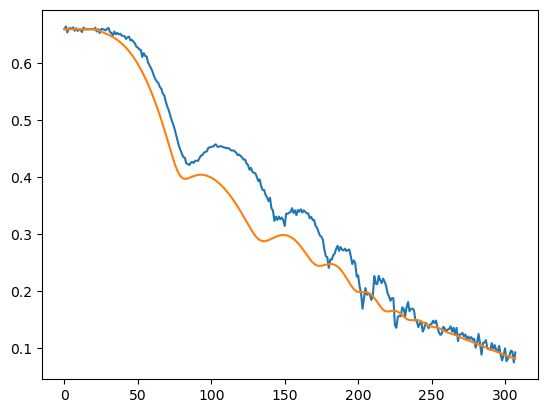

In [59]:
m = ReflectivityModels(x, 0)
m.generate(n=1)
for i in range(len(train_datasetIonic)):
    img, label = train_datasetIonic[i]
    if int(label[0].item()) == 194438:
        plt.plot(img.cpu().numpy()[0])
        # plt.show()
        break
m._refl_array[0] = np.log10(m._refl_array[0])
for i in range(len(m._refl_array[0])):
    m._refl_array[0][i] -= y_min
    m._refl_array[0][i] /= (y_max-y_min)
plt.plot(m._refl_array[0])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

In [44]:
torch.save(encoder, "../FullAE/encoder")

In [45]:
torch.save(decoder, "../FullAE/decoder")

In [59]:
torch.save(percep, "../FullAE/MLP")

In [12]:
encoder=torch.load("../FullAE/encoder",map_location='cuda')
encoder.eval()
loss_fn = torch.nn.MSELoss()

In [13]:
decoder=torch.load("../FullAE/decoder",map_location='cuda')
decoder.eval()
loss_fn = torch.nn.MSELoss()

In [62]:
percep=torch.load("../FullAE/MLP",map_location='cuda')
percep.eval()
loss_fn = torch.nn.MSELoss()